[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/weaviate/recipes/blob/main/integrations/operations/weights_and_biases/wandb_logging_RAG_dspy_cohere.ipynb)

### Weave is now integrated in DSPy. Please refer to [this page](https://wandb.github.io/weave/guides/integrations/dspy/) on how to add traces to your DSPy program.

# Setup
There are 4 basic steps to compile an LLM program with DSPy.

1. Connect DSPy to any LLMs or tools, such as Weaviate :), that you want to use.
2. Load your dataset, wrapping each example in a dspy.Example object.
3. Define your LLM program.
4. Define your Metric.

# 1. Connect DSPy to Command R and Weaviate

In [22]:
import dspy
from dspy.retrieve.weaviate_rm import WeaviateRM
import weaviate

# Connect LMs
command_r_plus = dspy.Cohere(model="command-r-plus", max_tokens=4000, api_key=cohere_api_key)
command_r = dspy.Cohere(model="command-r", max_tokens=4000, api_key=cohere_api_key)

# Connect to Weaviate
weaviate_client = weaviate.connect_to_local()
retriever_model = WeaviateRM("WeaviateBlogChunk", weaviate_client=weaviate_client)

# Set defaults in DSPy
dspy.settings.configure(lm=command_r, rm=retriever_model)

In [23]:
print(command_r("say hello"))
print(command_r_plus("say hello"))

["Hello! How's it going? I hope you're having a fantastic day! 😊"]
['Hello! How can I help you today?']


# 2. Load your Dataset

In [24]:
import json

file_path = './WeaviateBlogRAG-0-0-0.json'
with open(file_path, 'r') as file:
    dataset = json.load(file)

gold_answers = []
queries = []

for row in dataset:
    gold_answers.append(row["gold_answer"])
    queries.append(row["query"])
    
data = []

for i in range(len(gold_answers)):
    data.append(dspy.Example(gold_answer=gold_answers[i], question=queries[i]).with_inputs("question"))

trainset, devset, testset = data[:25], data[25:35], data[35:]

# 3. Define your LLM Program

In [26]:
class GenerateAnswer(dspy.Signature):
    """Assess the the context and answer the question."""

    context = dspy.InputField(desc="Helpful information for answering the question.")
    question = dspy.InputField()
    answer = dspy.OutputField(desc="A detailed answer that is supported by the context.")
    
class RAG(dspy.Module):
    def __init__(self, k=3):
        super().__init__()
        
        self.retrieve = dspy.Retrieve(k=k)
        self.generate_answer = dspy.Predict(GenerateAnswer)
    
    def forward(self, question):
        context = self.retrieve(question).passages
        pred = self.generate_answer(context=context, question=question).answer
        return dspy.Prediction(context=context, answer=pred, question=question)

# 4. Define your Metric

In [27]:
class TypedEvaluator(dspy.Signature):
    """Evaluate the quality of a system's answer to a question according to a given criterion.
    Please be a bit harsh, only give a 5 to a truly above and beyond answer.
    """
    
    criterion: str = dspy.InputField(desc="The evaluation criterion.")
    question: str = dspy.InputField(desc="The question asked to the system.")
    ground_truth_answer: str = dspy.InputField(desc="An expert written Ground Truth Answer to the question.")
    predicted_answer: str = dspy.InputField(desc="The system's answer to the question.")
    rating: float = dspy.OutputField(desc="A float rating between 1 and 5")


def MetricWrapper(gold, pred, trace=None):
    alignment_criterion = "How aligned is the predicted_answer with the ground_truth?"
    return dspy.TypedPredictor(TypedEvaluator)(criterion=alignment_criterion,
                                          question=gold.question,
                                          ground_truth_answer=gold.gold_answer,
                                          predicted_answer=pred.answer).rating

In [28]:
from dspy.evaluate.evaluate import Evaluate

evaluate = Evaluate(devset=devset, num_threads=4, display_progerss=False)

uncomplied_score = evaluate(RAG(), metric=MetricWrapper)

# Great! You are all setup to use DSPy's Compilers

# Connect to Weights & Biases and start a `run`

In [34]:
import wandb
import random

wandb.login()


wandb.init(
    # Set the project where this run will be logged
    project="bootstrapfewshot-gfl",
    # Name the experiment
    name="Command-R+-bootstrapped-scores",
    # Track hyperparameters and run metadata
    config={
        "teacher": "Command-R+",
        "inputs": 45,
    }
)

# logging is handled within DSPy

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


id,▄█▁
metric_val,▁▁▁
id,492688426
metric_val,4.0


/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


### Bootstrap with Command R+

In [35]:
from dspy.teleprompt import BootstrapFewShot

# Replace with Teacher Model

teacher_settings = {"lm": command_r_plus}

teleprompter = BootstrapFewShot(teacher_settings=teacher_settings,
                                    metric=MetricWrapper,
                                    metric_threshold=4.2,
                                    max_bootstrapped_demos=3, 
                                    max_rounds=1)
compiled_RAG = teleprompter.compile(RAG(), trainset=trainset, wandb_enabled=True) # Toggle Wandb logging on

100%|███████████████████████████████████████████| 25/25 [03:01<00:00,  7.25s/it]


In [36]:
compiled_RAG_score = evaluate(compiled_RAG, metric=MetricWrapper)
print(f"\033[91mCompiled RAG Score at Demos = {i}: {compiled_RAG_score}\n")

Compiled RAG Score at Demos = 49: 455.0



### Bootstrap with Command R

In [37]:
wandb.init(
    # Set the project where this run will be logged
    project="bootstrapfewshot-gfl",
    # Name the experiment
    name="Command-R-bootstrapped-scores",
    # Track hyperparameters and run metadata
    config={
        "teacher": "Command-R",
        "inputs": 45,
    }
)

/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


id,▂▇▆▄▅▅▁▂▅▇▂▂▆▃▇█▆▆▂▇▇█▃▂█
metric_val,▇▂█▇▇▁▁█▇▂▁▂▇█▇▇▇█▂▂▃▇█▃█
id,943520428
metric_val,3.7


/Users/cshorten/Desktop/DSPy-local/myenv/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [38]:
from dspy.teleprompt import BootstrapFewShot

# Replace with Teacher Model

teacher_settings = {"lm": command_r} # NOTE, we are bootstrapping with Command R here instead of Command R+!

teleprompter = BootstrapFewShot(teacher_settings=teacher_settings,
                                    metric=MetricWrapper,
                                    metric_threshold=4.2,
                                    max_bootstrapped_demos=3, 
                                    max_rounds=1)
compiled_RAG = teleprompter.compile(RAG(), trainset=trainset, wandb_enabled=True) # Toggle Wandb logging on

 52%|██████████████████████▎                    | 13/25 [00:19<00:17,  1.47s/it]


In [39]:
compiled_RAG_score = evaluate(compiled_RAG, metric=MetricWrapper)
print(f"\033[91mCompiled RAG Score at Demos = {i}: {compiled_RAG_score}\n")

Compiled RAG Score at Demos = 49: 420.0



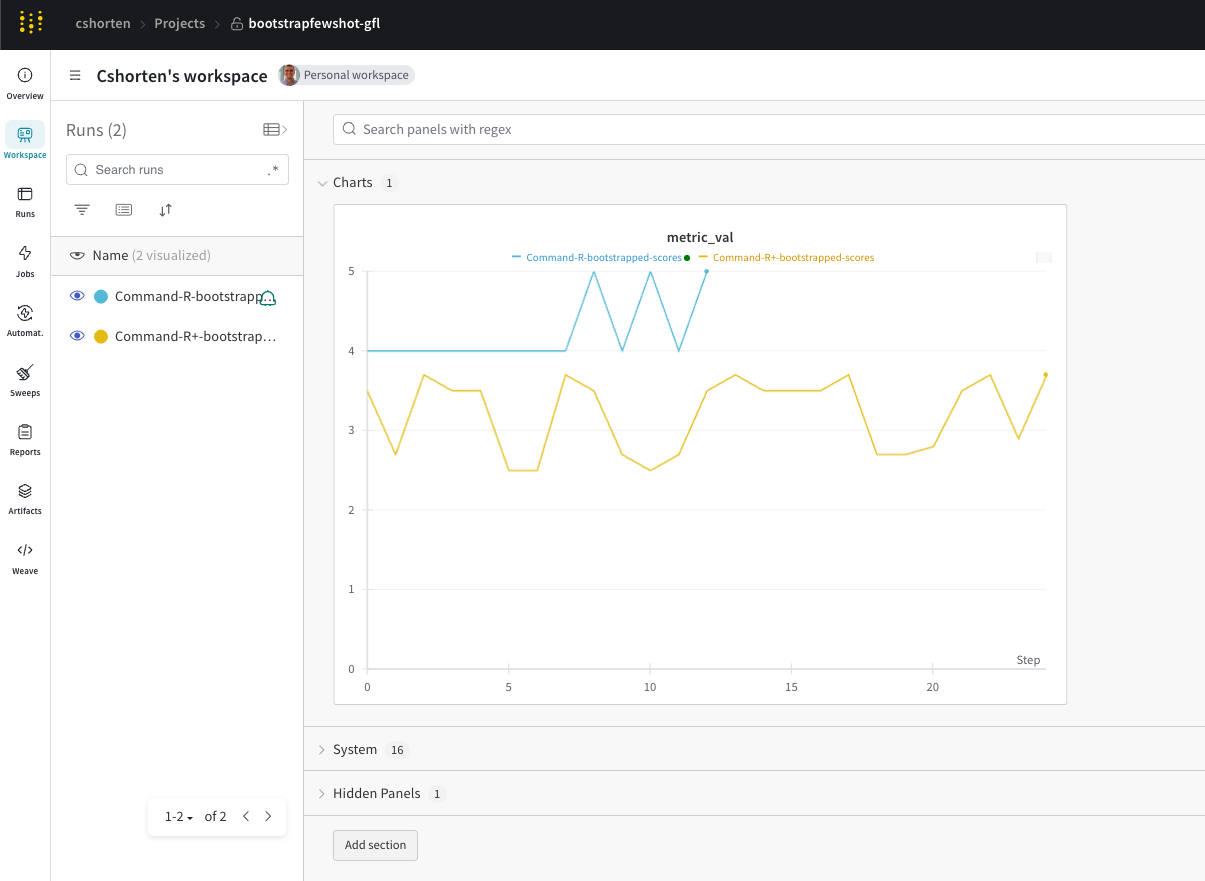

In [42]:
from IPython.display import Image, display

display(Image(filename='./RAG-optimization-dashboard.png'))
